# Bias-Variance Visualizations

In this example, we will look at four different models with the different possible combinations of bias and variance (high and low). Histograms will be constructed for error over five iterations of training and testing. Then we will calculate the average loss, average bias, average variance, and net variance over 100 iterations of training and testing.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from sklearn.datasets import fetch_california_housing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

from mvtk.bias_variance import bias_variance_compute, bias_variance_mse, bootstrap_train_and_predict
from mvtk.bias_variance.estimators import EstimatorWrapper, PyTorchEstimatorWrapper, SciKitLearnEstimatorWrapper

I0000 00:00:1701450524.267373       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


In [2]:
random_state=123
trials_graph=5
trials_full=100
bins=20

## Load the example dataset and create helper functions

In [3]:
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

In [4]:
import warnings

def predict_trials(estimator, X_train, y_train, X_test, iterations, random_state, fit_kwargs=None, predict_kwargs=None):
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        predictions = np.zeros((iterations, y_test.shape[0]), dtype=np.float64)
    
        for i in range(iterations):
            predictions[i] = bootstrap_train_and_predict(estimator, X_train, y_train, X_test, random_state=random_state, 
                                                         fit_kwargs=fit_kwargs, predict_kwargs=predict_kwargs)
    
        return predictions

In [5]:
def graph_trials(predictions, y_test, bins):
    error_graph = np.swapaxes(predictions - y_test, 0, 1)

    plt.hist(error_graph, bins, density=True, label=[f'Trial {x}' for x in range(1, predictions.shape[0] + 1)])
    plt.xlabel('mean squared error')
    plt.legend()

## Label Distribution

First, let's take a look at the distribution of the labels. Notice that the majority of label values are around 1 and 2, and much less around 5.

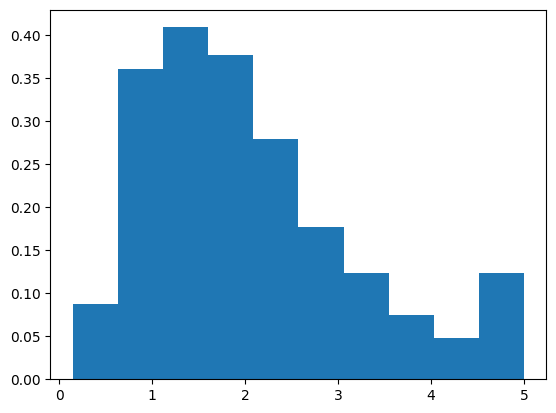

In [6]:
plt.hist(y, density=True)
plt.savefig('bias_variance_label_distribution.png')

## High Bias Low Variance Example

We will introduce an artificial bias to a Scikit-Learn Linear Regression model by adding 10 to every label of the training label set. Given that values of greater than 5 in the entire label set are considered outliers, we are fitting the model against outliers.

In [7]:
model_bias = LinearRegression()
model_bias_wrapped = SciKitLearnEstimatorWrapper(model_bias)

# add artificial bias to training labels
y_train_bias = y_train + 10

In [8]:
pred_bias = predict_trials(model_bias_wrapped, X_train, y_train_bias, X_test, trials_graph, random_state)

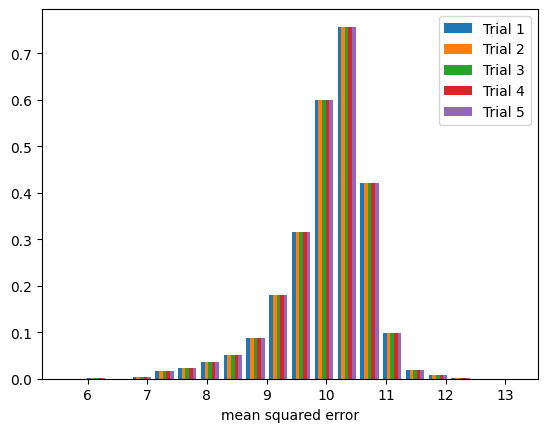

In [9]:
graph_trials(pred_bias, y_test, bins)
plt.savefig('high_bias_low_variance.png')

Notice in the figure above that the model error is very consistent among the trials and is not centered around 0.

Next we calculate the values over 100 trials.

In [10]:
avg_loss, avg_bias, avg_var, net_var = bias_variance_compute(model_bias_wrapped, X_train, y_train_bias, X_test, y_test, 
                                                             iterations=trials_full, random_state=random_state, 
                                                             decomp_fn=bias_variance_mse)

print(f'average loss: {avg_loss:10.8f}')
print(f'average bias: {avg_bias:10.8f}')
print(f'average variance: {avg_var:10.8f}')
print(f'net variance: {net_var:10.8f}')

average loss: 100.73667218
average bias: 100.64990963
average variance: 0.08676256
net variance: 0.08676256


## Low Bias High Variance Example

To simulate a higher variance, we will introduce 8 random "noise" features to the data set. We will also reduce the size of the training set and train a PyTorch neural network over a low number of epochs.

In [11]:
class ModelPyTorch(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(16, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 16)
        self.linear4 = nn.Linear(16, 8)
        self.linear5 = nn.Linear(8, 1)
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        x = self.linear3(x)
        x = self.linear4(x)
        x = self.linear5(x)
        return x

In [12]:
model_variance = ModelPyTorch()
optimizer = torch.optim.Adam(model_variance.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [13]:
def optimizer_generator(x):
    return torch.optim.Adam(x.parameters(), lr=0.001)

model_variance_wrapped = PyTorchEstimatorWrapper(model_variance, optimizer_generator, loss_fn)

In [14]:
X_train_torch = torch.FloatTensor(np.append(X_train.values[:100], 1000 * np.random.random_sample((100, 8)), axis=1))
X_test_torch = torch.FloatTensor(np.append(X_test.values, 1000 * np.random.random_sample((6192, 8)), axis=1))
y_train_torch = torch.FloatTensor(y_train[:100]).reshape(-1, 1)
y_test_torch = torch.FloatTensor(y_test).reshape(-1, 1)

In [15]:
pred_variance = predict_trials(model_variance_wrapped, X_train_torch, y_train_torch, X_test_torch, trials_graph, random_state,
                               fit_kwargs={'epochs': 20})

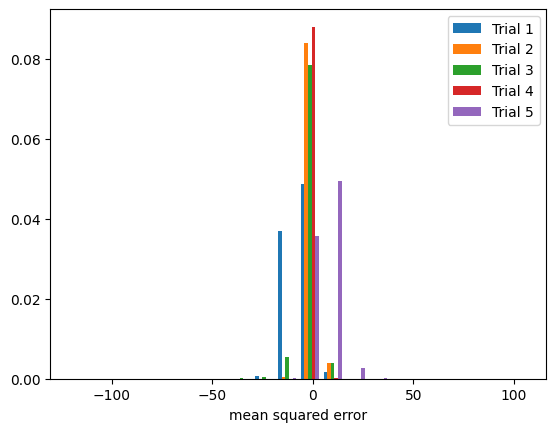

In [16]:
graph_trials(pred_variance, y_test, bins)
plt.savefig('low_bias_high_variance.png')

Notice in the figure above that the model error has different distributions among the trials and centers mainly around 0.

Next we calculate the values over 100 trials.

In [17]:
avg_loss, avg_bias, avg_var, net_var = bias_variance_compute(model_variance_wrapped, X_train_torch, y_train_torch, 
                                                             X_test_torch, y_test, iterations=trials_full, 
                                                             random_state=random_state, decomp_fn=bias_variance_mse, 
                                                             fit_kwargs={'epochs': 20})

print(f'average loss: {avg_loss:10.8f}')
print(f'average bias: {avg_bias:10.8f}')
print(f'average variance: {avg_var:10.8f}')
print(f'net variance: {net_var:10.8f}')

average loss: 95.16939162
average bias: 2.09532483
average variance: 93.07406679
net variance: 93.07406679


## High Bias High Variance Example

We will perform a combination of the techniques from the high bias low variance example and the low bias high variance example and train another PyTorch neural network.

In [18]:
model_bias_variance = ModelPyTorch()
optimizer = torch.optim.Adam(model_bias_variance.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

In [19]:
# Add artificial bias to the training labels
y_train_torch_bias_variance = torch.FloatTensor(y_train[:100] + 10).reshape(-1, 1)

In [20]:
def optimizer_generator(x):
    return torch.optim.Adam(x.parameters(), lr=0.001)

model_bias_variance_wrapped = PyTorchEstimatorWrapper(model_bias_variance, optimizer_generator, loss_fn)

In [21]:
pred_bias_variance = predict_trials(model_bias_variance_wrapped, X_train_torch, y_train_torch_bias_variance, 
                                    X_test_torch, trials_graph, random_state,
                                    fit_kwargs={'epochs': 20})

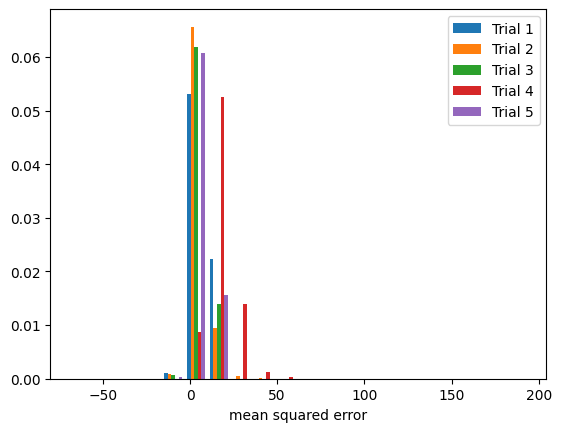

In [22]:
graph_trials(pred_bias_variance, y_test, bins)
plt.savefig('high_bias_high_variance.png')

Notice in the figure above that the model error has different distributions among the trials and is not centered around 0.

Next we calculate the values over 100 trials.

In [23]:
avg_loss, avg_bias, avg_var, net_var = bias_variance_compute(model_bias_variance_wrapped, X_train_torch, y_train_torch_bias_variance, 
                                                             X_test_torch, y_test, iterations=trials_full, 
                                                             random_state=random_state, decomp_fn=bias_variance_mse, 
                                                             fit_kwargs={'epochs': 20})

print(f'average loss: {avg_loss:10.8f}')
print(f'average bias: {avg_bias:10.8f}')
print(f'average variance: {avg_var:10.8f}')
print(f'net variance: {net_var:10.8f}')

average loss: 172.72894068
average bias: 79.38170440
average variance: 93.34723628
net variance: 93.34723628


## Low Bias Low Variance Example

Now we will train a Scikit Learn Linear Regression with no artificial bias.

In [24]:
# Low bias low variance
model = LinearRegression()

model_wrapped = SciKitLearnEstimatorWrapper(model)

In [25]:
pred = predict_trials(model_wrapped, X_train, y_train, X_test, trials_graph, random_state)

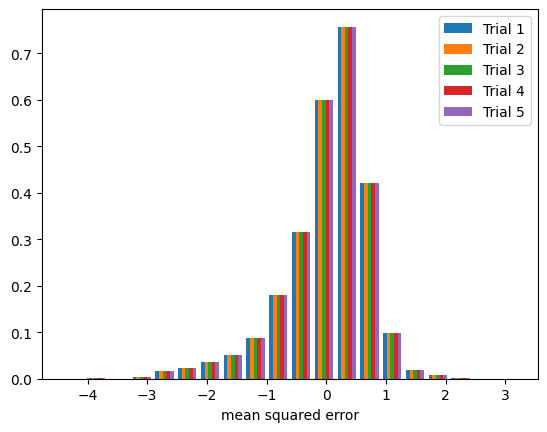

In [26]:
graph_trials(pred, y_test, bins)
plt.savefig('low_bias_low_variance.png')

Notice in the figure above that the model error is very consistent among the trials and centers mainly around 0.

Next we calculate the values over 100 trials.

In [27]:
avg_loss, avg_bias, avg_var, net_var = bias_variance_compute(model_wrapped, X_train, y_train, X_test, y_test, iterations=trials_full, 
                                                             random_state=random_state, decomp_fn=bias_variance_mse)

print(f'average loss: {avg_loss:10.8f}')
print(f'average bias: {avg_bias:10.8f}')
print(f'average variance: {avg_var:10.8f}')
print(f'net variance: {net_var:10.8f}')

average loss: 0.60725048
average bias: 0.52048793
average variance: 0.08676256
net variance: 0.08676256
